# Time Series Modeling

In [2]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

https://content.bellevue.edu/cst/dsc/630/us_retail_sales.csv

This data gives the total monthly retail sales in the US from January 1992 until June 2021.

In [4]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import numpy as np

# Load dataset
file_path = "us_retail_sales.csv"
df = pd.read_csv(file_path)

# Display the first 5 rows
print("First 5 rows:")
print(df.head(5))


First 5 rows:
   YEAR     JAN     FEB     MAR     APR     MAY     JUN       JUL       AUG  \
0  1992  146925  147223  146805  148032  149010  149800  150761.0  151067.0   
1  1993  157555  156266  154752  158979  160605  160127  162816.0  162506.0   
2  1994  167518  169649  172766  173106  172329  174241  174781.0  177295.0   
3  1995  182413  179488  181013  181686  183536  186081  185431.0  186806.0   
4  1996  189135  192266  194029  194744  196205  196136  196187.0  196218.0   

        SEP       OCT       NOV       DEC  
0  152588.0  153521.0  153583.0  155614.0  
1  163258.0  164685.0  166594.0  168161.0  
2  178787.0  180561.0  180703.0  181524.0  
3  187366.0  186565.0  189055.0  190774.0  
4  198859.0  200509.0  200174.0  201284.0  


In [5]:
# Print column names
df.columns

Index(['YEAR', 'JAN', 'FEB', 'MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP',
       'OCT', 'NOV', 'DEC'],
      dtype='object')

## 1. Plot the data with proper labeling and make some observations on the graph

In [7]:
# df.melt(...) is used to reshape a DataFrame from a wide format to a long format.

# id_vars='YEAR': Keeps the YEAR column fixed (not melted).

# var_name='MONTH': Names the new column that holds the former column headers (JAN, FEB, etc.).

# value_name='RETAIL_SALES': Names the new column that holds the sales values.

df_long = df.melt(id_vars='YEAR', var_name='MONTH', value_name='RETAIL_SALES')

# print new dataframe
print(df_long)

     YEAR MONTH  RETAIL_SALES
0    1992   JAN      146925.0
1    1993   JAN      157555.0
2    1994   JAN      167518.0
3    1995   JAN      182413.0
4    1996   JAN      189135.0
..    ...   ...           ...
355  2017   DEC      433282.0
356  2018   DEC      434803.0
357  2019   DEC      458055.0
358  2020   DEC      484782.0
359  2021   DEC           NaN

[360 rows x 3 columns]


In [8]:
# Map month names to numbers
# Creates a dictionary to convert month names (like 'JAN') into numerical values (1 for January, ..., 12 for December).

# .map(month_map) applies this conversion to the MONTH column, and the result is stored in a new column MONTH_NUM.
    
month_map = {'JAN': 1, 'FEB': 2, 'MAR': 3, 'APR': 4, 'MAY': 5, 'JUN': 6,
             'JUL': 7, 'AUG': 8, 'SEP': 9, 'OCT': 10, 'NOV': 11, 'DEC': 12}
df_long['MONTH_NUM'] = df_long['MONTH'].map(month_map)

# Clean up any remaining rows with missing values in required columns
df_final = df_long.dropna(subset=['YEAR', 'MONTH', 'MONTH_NUM', 'RETAIL_SALES'])

# Ensure 'RETAIL_SALES' is numeric
df_final['RETAIL_SALES'] = pd.to_numeric(df_final['RETAIL_SALES'])

# Create a datetime column
# Creating a proper datetime column for time series analysis.
# Sorting, filtering, or plotting data chronologically.

df_final['DATE'] = pd.to_datetime(
    dict(year=df_final['YEAR'], month=df_final['MONTH_NUM'], day=1)
)

# Sort by date
df_final = df_final.sort_values('DATE')

# Display the first 5 rows
print("First 5 rows:")
print(df_final.head(5))

First 5 rows:
     YEAR MONTH  RETAIL_SALES  MONTH_NUM       DATE
0    1992   JAN      146925.0          1 1992-01-01
30   1992   FEB      147223.0          2 1992-02-01
60   1992   MAR      146805.0          3 1992-03-01
90   1992   APR      148032.0          4 1992-04-01
120  1992   MAY      149010.0          5 1992-05-01


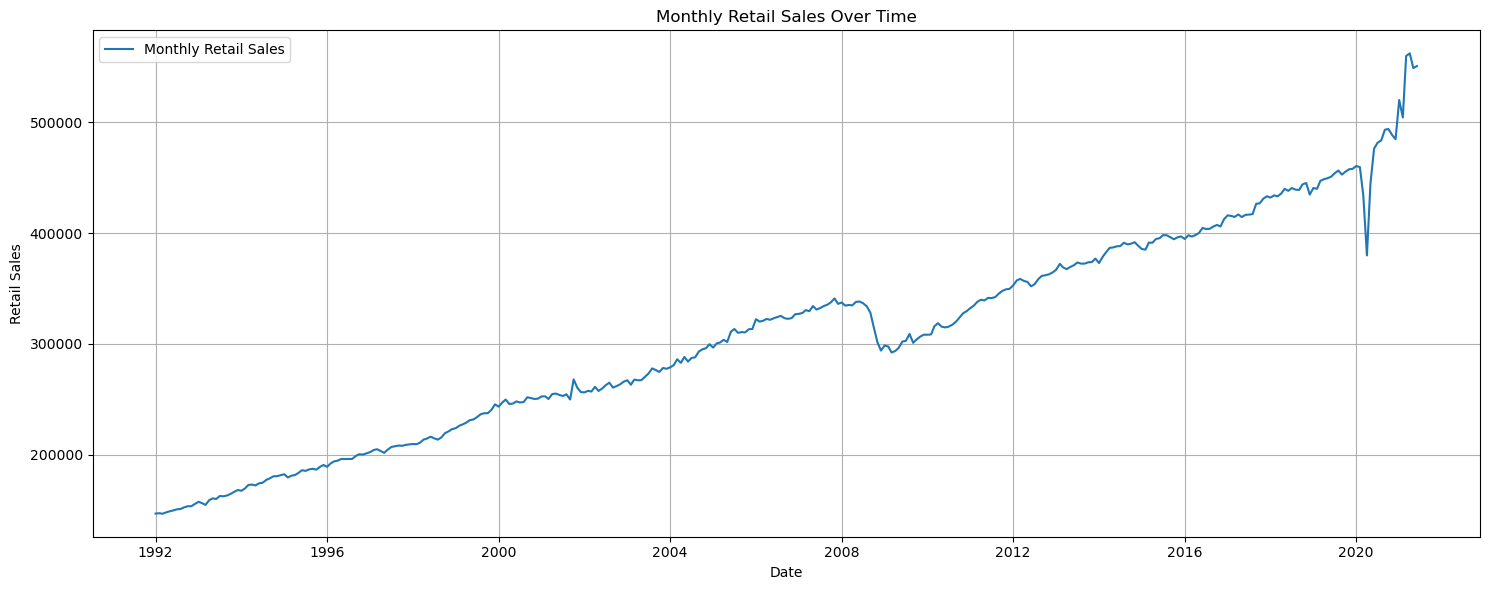

In [9]:
# Plot the data
plt.figure(figsize=(15, 6))
plt.plot(df_final['DATE'], df_final['RETAIL_SALES'], label='Monthly Retail Sales')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.title('Monthly Retail Sales Over Time')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

The plot shows a steady upward trend in monthly retail sales from 1992 to early 2020, with a noticeable dip around April 2020 due to the COVID-19 pandemic, followed by a sharp rebound.

## 2. Split this data into a training and test set. Use the last year of data (July 2020 – June 2021) of data as your test set and the rest as your training set.

In [12]:
# Select all rows where the date is before July 1, 2020.
#These rows become your training data — the model learns patterns from this.
train = df_final[df_final['DATE'] < '2020-07-01'] 

# Selects rows from July 1, 2020, to June 30, 2021 (12 months).
# These are the test data — used to evaluate how well the model generalizes to unseen data.
test = df_final[(df_final['DATE'] >= '2020-07-01') & (df_final['DATE'] < '2021-07-01')]

# Use ordinal dates as features
# preparing the training data for use in a machine learning model like linear regression, 
# by converting dates into a numeric format.
# Converts each date to an integer ordinal, i.e., the number of days since January 1, year 1, 
#for e.g 2020-07-01 → 737610
# 2020-07-02 → 737611
train_X = train['DATE'].map(pd.Timestamp.toordinal).values.reshape(-1, 1) 
train_y = train['RETAIL_SALES'].values

test_X = test['DATE'].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
test_y = test['RETAIL_SALES'].values

## 3. Use the training set to build a predictive model for the monthly retail sales.

In [14]:
# Train linear regression model
model = LinearRegression()

# train_X: the input features (ordinal dates),
# train_y: the output target (retail sales).
model.fit(train_X, train_y)

LinearRegression()

## 4. Use the model to predict the monthly retail sales on the last year of data.


In [16]:
# The model learns the best-fitting line that minimizes the squared error between predicted and actual retail sales.
# Predict on the test set
predictions = model.predict(test_X)

## 5. Calculate RMSE

In [18]:
# mean_squared_error(test_y, predictions):

# Calculates the average of the squared differences between:

# test_y: actual retail sales in the test set

# predictions: model's predicted retail sales

# np.sqrt(...): to take the square root of the Mean Squared Error to get RMSE, which is in the same units as the target (retail sales).

rmse = np.sqrt(mean_squared_error(test_y, predictions))
rmse

66429.10224838056

The Root Mean Square Error (RMSE) of the linear regression model's predictions on the test set (July 2020 – June 2021) is approximately 66,429, indicating the average deviation of predictions from actual values in that period.


### Seasonal model using SARIMA, which is more suitable when the data shows repeating yearly patterns, like retail sales often do.


 Use seasonal order (P, D, Q, s) with s=12 for yearly seasonality (12 months):

 There are four seasonal elements that are not part of ARIMA that must be configured; they are:

 P: Seasonal autoregressive order.
 D: Seasonal difference order.
 Q: Seasonal moving average order.
 m: The number of time steps for a single seasonal period.
 Together, the notation for an SARIMA model is specified as:
 e.g. SARIMA(3,1,0)(1,1,0)12<br>
 the m parameter influences the P, D, and Q parameters. For example, an m of 12 for monthly data suggests a yearly seasonal cycle.
<br>
 A P=1 would make use of the first seasonally offset observation in the model, e.g. t-(m*1) or t-12. A P=2, 
   would use the last two seasonally offset observations t-(m * 1), t-(m * 2).
<br>
 Similarly, a D of 1 would calculate a first order seasonal difference and a Q=1 would use a first order errors in the model (e.g. moving average).
<br>

 specify training data<br>
data = ... <br>
 define model configuration<br>
my_order = (1, 1, 1)<br>
my_seasonal_order = (1, 1, 1, 12)<br>
define model<br>
model = SARIMAX(data, order=my_order, seasonal_order=my_seasonal_order, ...)<br>

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [85]:
# Suppress all warnings
warnings.filterwarnings("ignore")


# SARIMA(p,d,q)(P,D,Q,s)
model_sarima = SARIMAX(train['RETAIL_SALES'],
                       order=(1, 1, 1),           # Non-seasonal order
                       seasonal_order=(1, 1, 1, 12), # Seasonal order
                       enforce_stationarity=False,
                       enforce_invertibility=False)

fitted_sarima = model_sarima.fit()
print(fitted_sarima.summary())


                                     SARIMAX Results                                      
Dep. Variable:                       RETAIL_SALES   No. Observations:                  342
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -3210.179
Date:                            Fri, 02 Jan 2026   AIC                           6430.359
Time:                                    23:58:19   BIC                           6449.122
Sample:                                         0   HQIC                          6437.855
                                            - 342                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5570      0.083      6.676      0.000       0.393       0.721
ma.L1         -0.7234      0.079   

In [23]:
## Step 3: Forecast Using SARIMA

In [87]:
# Suppress all warnings
warnings.filterwarnings("ignore")
forecast_sarima = fitted_sarima.forecast(steps=12)
forecast_sarima.index = test.index

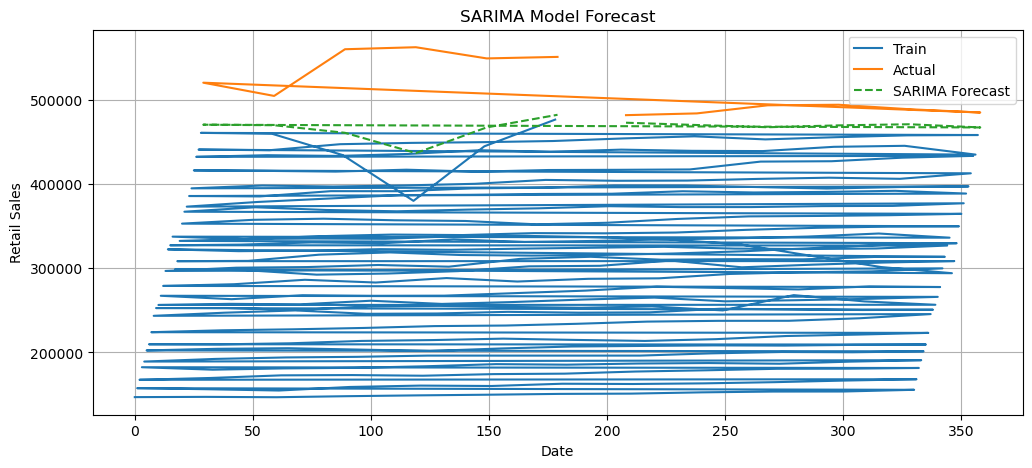

In [25]:
plt.figure(figsize=(12, 5))
plt.plot(train.index, train['RETAIL_SALES'], label='Train')
plt.plot(test.index, test['RETAIL_SALES'], label='Actual')
plt.plot(forecast_sarima.index, forecast_sarima, label='SARIMA Forecast', linestyle='--')
plt.title('SARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.legend()
plt.grid(True)
plt.show()


In [26]:
from sklearn.metrics import mean_squared_error

rmse_sarima = np.sqrt(mean_squared_error(test['RETAIL_SALES'], forecast_sarima))
print(f'SARIMA RMSE: {rmse_sarima:.2f}')

SARIMA RMSE: 59819.07


## Build ARIMA Model on Training Set

In [28]:
from statsmodels.tsa.arima.model import ARIMA


In [29]:
df_final.set_index('DATE', inplace=True)
df_final = df_final.asfreq('MS')  # Monthly Start


In [30]:
# # Use the last 12 months (July 2020 – June 2021) as the test set:
# train = df_final.loc[:'2020-06-01']
# test = df_final.loc['2020-07-01':'2021-06-01']

In [80]:
# Suppress all warnings
warnings.filterwarnings("ignore")
# Start with ARIMA(1,1,1) as a basic model. You can tune it later.

model = ARIMA(train['RETAIL_SALES'], order=(1, 1, 1))  # ARIMA(p,d,q)
fitted_model = model.fit()
print(fitted_model.summary())

                               SARIMAX Results                                
Dep. Variable:           RETAIL_SALES   No. Observations:                  342
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3446.039
Date:                Fri, 02 Jan 2026   AIC                           6898.078
Time:                        23:56:34   BIC                           6909.574
Sample:                             0   HQIC                          6902.658
                                - 342                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5740      0.288      1.991      0.046       0.009       1.139
ma.L1         -0.6137      0.287     -2.142      0.032      -1.175      -0.052
sigma2      3.464e+07    1.6e-07   2.17e+14      0.0

In [82]:
# Suppress all warnings
warnings.filterwarnings("ignore")
forecast = fitted_model.forecast(steps=12)
forecast.index = test.index  # align forecast index to test

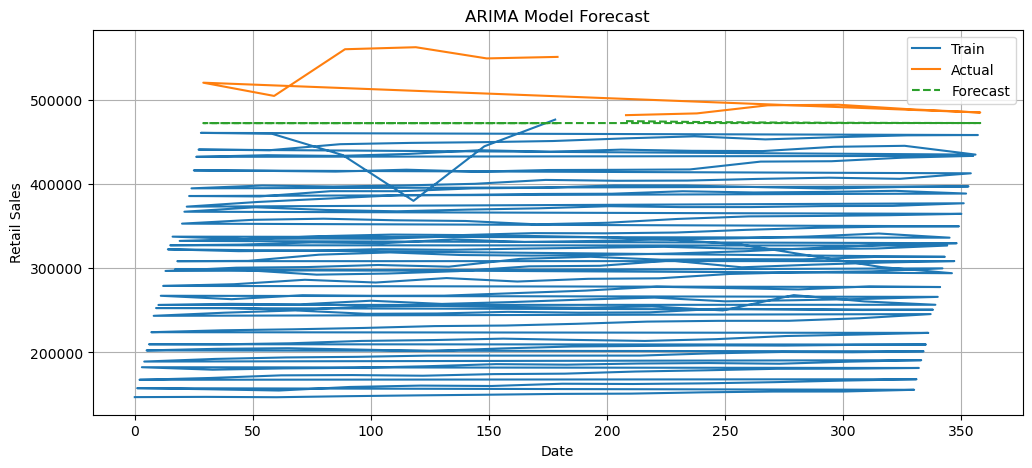

In [33]:
#  Step 6: Visualize Actual vs Forecasted Sales

plt.figure(figsize=(12, 5))
plt.plot(train.index, train['RETAIL_SALES'], label='Train')
plt.plot(test.index, test['RETAIL_SALES'], label='Actual')
plt.plot(forecast.index, forecast, label='Forecast', linestyle='--')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Retail Sales')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
# Evaluate Model Performance (RMSE)
rmse = np.sqrt(mean_squared_error(test['RETAIL_SALES'], forecast))
print(f'RMSE on test set: {rmse:.2f}')

RMSE on test set: 52206.76


First, using linear regression to model time series data. (Ordinary) linear regression is not a good model for time series data because one of the assumptions for linear regression is that the independence of observations, obviously, time series data doesn't satisfy this assumption - although you may see someone use it to handle time series data, it's not a good choice.
Second, using ARIMA or SARIMA to model time series data without any explanation for the choice of "order parameters". You need to give some reasons why you choose those parameters. If you are not sure, autocorrelation function (ACF) and partial autocorrelation function (PACF) can aid you to find appropriate order parameters.
You can also use "auto_arima()" to help you find the appropriate "order parameters, i.e. p, d, q"
 
Another option is “prophet” library in Python/R

selecting the ARIMA/SARIMA model's order parameters 
(
𝑝
,
𝑑
,
𝑞
)
(p,d,q) and seasonal components 
(
𝑃
,
𝐷
,
𝑄
,
𝑠
)
(P,D,Q,s) should be data-driven rather than arbitrary. Below is a proper methodology to determine these parameters using both ACF/PACF plots and auto_arima()

## Step 1: Check Stationarity (for d)
Use the Augmented Dickey-Fuller (ADF) test to determine whether differencing is needed:

In [38]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train['RETAIL_SALES'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -0.6092151519257174
p-value: 0.8688861548705527


If p-value < 0.05, data is stationary → d = 0

If p-value ≥ 0.05, data is non-stationary → apply differencing → d = 1

<Axes: title={'center': '1st Order Differenced Series'}>

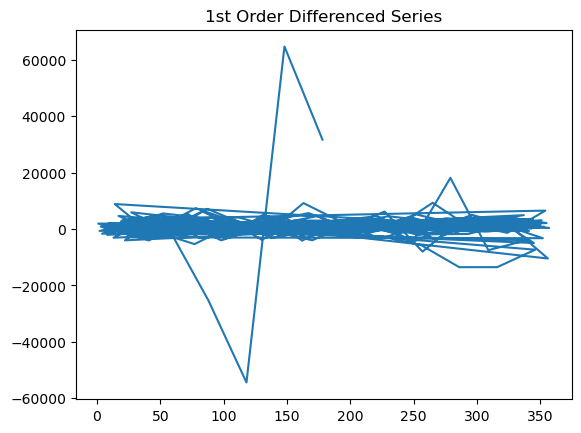

In [40]:
train['RETAIL_SALES'].diff().dropna().plot(title='1st Order Differenced Series')


## Step2: Plot ACF and PACF (for p, q)

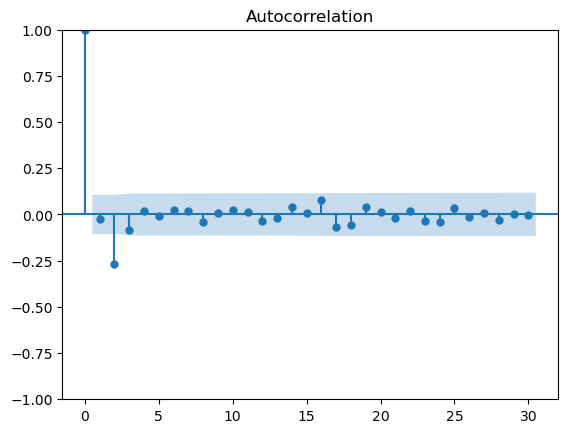

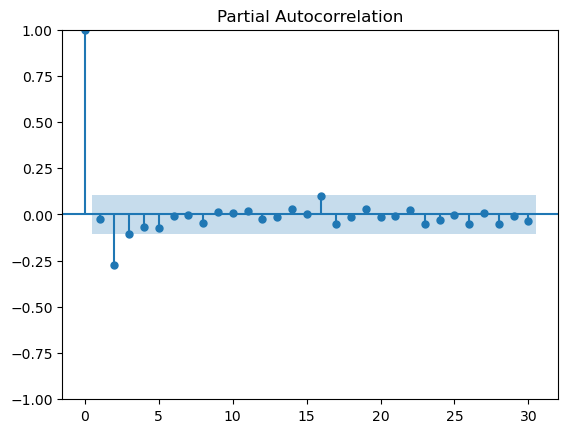

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(train['RETAIL_SALES'].diff().dropna(), lags=30)
plot_pacf(train['RETAIL_SALES'].diff().dropna(), lags=30)
plt.show()


ACF helps suggest q (MA component) — significant spikes = order.

PACF helps suggest p (AR component).

Example interpretation:

If PACF cuts off after lag 1 → suggest p = 1

If ACF cuts off after lag 1 → suggest q = 1



## Step3: Use auto_arima() to Automate Selection

In [45]:
import pmdarima as pm

model_auto = pm.auto_arima(train['RETAIL_SALES'],
                           seasonal=True,
                           m=12,               # monthly seasonality
                           stepwise=True,
                           trace=True,
                           suppress_warnings=True)

print(model_auto.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=1.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=6888.728, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=6892.499, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6892.619, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=6895.872, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=6890.620, Time=0.10 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=6890.610, Time=0.11 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=6892.598, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=6890.613, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=6890.751, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=6892.014, Time=0.19 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12] intercept
Total fit time: 2.948 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:           

This will return the best (p, d, q) and (P, D, Q, s) using AIC minimization.



In [76]:
import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")
# Best model: SARIMA(1, 1, 1)(0, 1, 1, 12)

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train['RETAIL_SALES'],
                order=(1,1,1),
                seasonal_order=(0,1,1,12))
result = model.fit()
print(result.summary())



                                     SARIMAX Results                                      
Dep. Variable:                       RETAIL_SALES   No. Observations:                  342
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3365.501
Date:                            Fri, 02 Jan 2026   AIC                           6739.003
Time:                                    23:55:53   BIC                           6754.187
Sample:                                         0   HQIC                          6745.060
                                            - 342                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6886      0.175      3.933      0.000       0.345       1.032
ma.L1         -0.7599      0.172   